In [6]:
import sys
sys.path.append('../')
from src import util, logit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import gridspec
%matplotlib inline

In [46]:
def make_heatmap(ax, Z, actual_r, actual_p, title="Log-likelihood", step=0.025):
    rs = np.arange(0.0, 1.0 + step, step)
    ps = np.arange(1.0, 0-step, -step)
    X, Y = np.meshgrid(rs, ps)
    i,j = np.unravel_index(np.nanargmin(Z), Z.shape)  # get empirical maximum
    # make the plot
    ax.imshow(Z, cmap=cm.coolwarm)
    ax.set_xticks(np.arange(0, (1.0/step) + 0.05, (1.0/step)/4))
    ax.set_xticklabels(np.arange(0.0, 1.05, 0.25))
    ax.set_yticks(np.arange(0,  (1.0/step) + 0.05, (1.00/step)/4))
    ax.set_yticklabels(np.arange(1, -.01, -0.25))
    ax.set_xlabel(r'$r$')
    ax.set_ylabel(r'$p$')
    ax.plot((1.00/step)/4 * actual_r * (1/0.25),
            (1.00/step)/4 * (1-actual_p) * (1/0.25),
            'o', color='green')  # actual
    ax.plot(j, i, 'o', color='black')  # empirical max
    ax.set_title(title)

In [8]:
def make_z(D, step=0.025):
    rs = np.arange(0.0, 1.0 + step, step)
    ps = np.arange(1.0, 0-step, -step)
    X, Y = np.meshgrid(rs, ps)
    # apply util.manual_ll to each value of (alpha, p)
    Z = np.sqrt(X**2 + Y**2)  # to initialize the meshgrid
    # compute each case
    # (r=1, p=1) - PA on all nodes
    D['score'] = D['deg']
    r1p1 = np.nan_to_num(np.array(D.loc[D.y == 1, 'score']) / D.groupby('choice_id')['score'].aggregate(np.sum))
    # (r=0, p=1) - PA on FoFs only
    D['score'] = np.where(D['fof'] > 0, D['deg'], 0)
    r0p1 = np.nan_to_num(np.array(D.loc[D.y == 1, 'score']) / D.groupby('choice_id')['score'].aggregate(np.sum))
    # (r=1, p=0) - uniform on all nodes
    D['score'] = 1
    r1p0 = np.nan_to_num(np.array(D.loc[D.y == 1, 'score']) / D.groupby('choice_id')['score'].aggregate(np.sum))  
    # (r=0, p=0) - uniform on FoFs only
    D['score'] = np.where(D['fof'] > 0, 1, 0)
    r0p0 = np.nan_to_num(np.array(D.loc[D.y == 1, 'score']) / D.groupby('choice_id')['score'].aggregate(np.sum))
    for i in range(len(rs)):
        for j in range(len(ps)):
            r = rs[i]
            p = ps[j]           
            scores_final = p*(r*r1p1 + (1-r)*r0p1) + (1-p)*(r*r1p0 + (1-r)*r0p0)
            Z[j, i] = -1 * np.nansum(np.log(scores_final + util.log_smooth))
    return Z

Plot a single combination.

In [ ]:
r = 0
p = 0.5
step = 0.05
Ds = util.read_data_single('g-%.2f-%.2f-00.csv' % (r, p))
Zs = make_z(Ds, step=step)
#Zs = np.where(Zs > 50000, 50000, Zs)
Zs[:,0] = np.nan
f, ax = plt.subplots()
make_heatmap(ax, Zs, r, p, title="(%.2f, %.2f)" % (r, p), step=step)

Plot many combinations

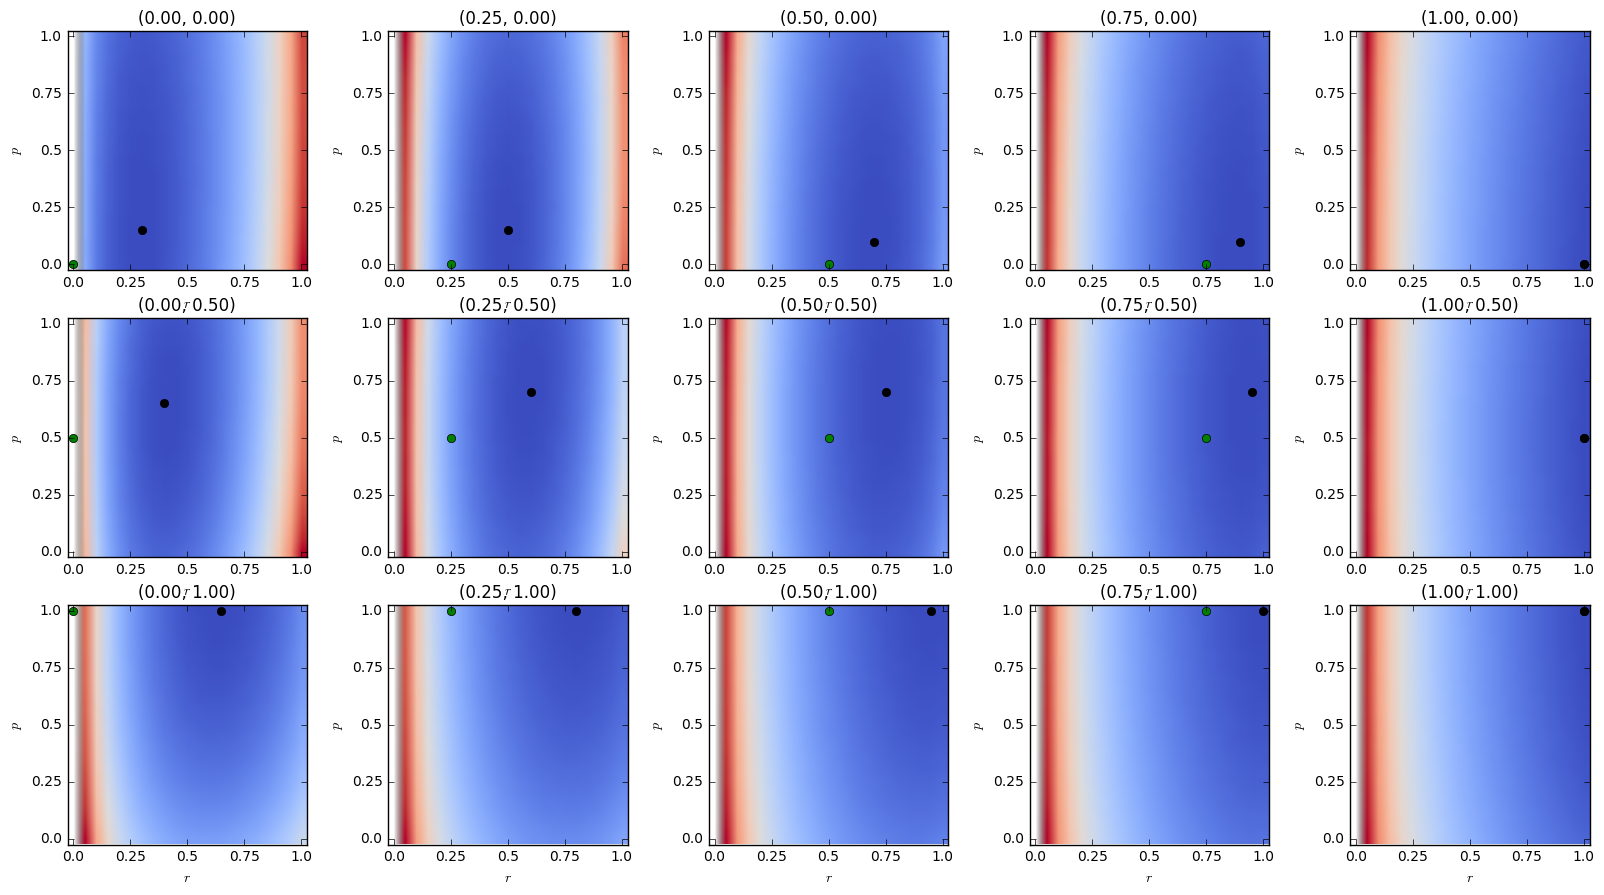

In [40]:
fig = plt.figure(figsize=(20, 10.5))
gs = gridspec.GridSpec(3, 5)
i = 0
step = 0.05
for p in [0, 0.5, 1]:
    for r in [0, 0.25, 0.5, 0.75, 1]:
        Da = util.read_data_single('g-%.2f-%.2f-00.csv' % (r, p))
        Za = make_z(Da, step=step)
        Za[:,0] = np.nan
        #Za = np.where(Za > 50000, 50000, Za)
        ax = fig.add_subplot(gs[i])
        make_heatmap(ax, Za, r, p, title="(%.2f, %.2f)" % (r, p), step=step)   
        i += 1
fig.show()

Now $p$ doesn't matter practically at all, but the empirical maximum does follow the actual parameters.

Here, try a second variant where we actually call `MixedLogitModel`, set $\pi_{r,p}$ according to $r,p$ and compute the LL.

In [14]:
def make_z2(D, step=0.025):
    rs = np.arange(0.0, 1.0 + step, step)
    ps = np.arange(1.0, 0-step, -step)
    X, Y = np.meshgrid(rs, ps)
    Z = np.sqrt(X**2 + Y**2)  # to initialize the meshgrid
    m = logit.MixedLogitModel('tmp', D=D, vvv=0)
    m.add_uniform_model()
    m.add_log_degree_model(bounds=((1, 1),))  # clamped at alpha=1 (full PA)
    m.add_uniform_fof_model()
    m.add_log_degree_fof_model(bounds=((1, 1),)) # clamped at alpha=1 (full PA)
    for i in range(len(rs)):
        for j in range(len(ps)):
            r = rs[i]
            p = ps[j]
            m.pk = {0: (1-p)*r, 1: p*r, 2: (1-p)*(1-r), 3: p*(1-r)}
            Z[j, i] = m.ll()
    return Z

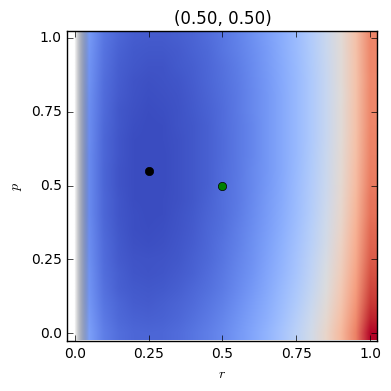

In [64]:
r = 0.5
p = 0.5
step = 0.05
Ds = util.read_data_single('g-%.2f-%.2f-00.csv' % (r, p))
Zs = make_z2(Ds, step=step)
# different strategies with removing the very low LL of r=0...
#Zs[:,0] = np.nan
#Zs = np.where(Zs > 22000, 22000, Zs)
Zs[:,0] = np.where(np.abs(Zs[:,0] / Zs[:,1]) > 1.2, np.nan, Zs[:,0])
f, ax = plt.subplots()
make_heatmap(ax, Zs, r, p, title="(%.2f, %.2f)" % (r, p), step=step)

same...

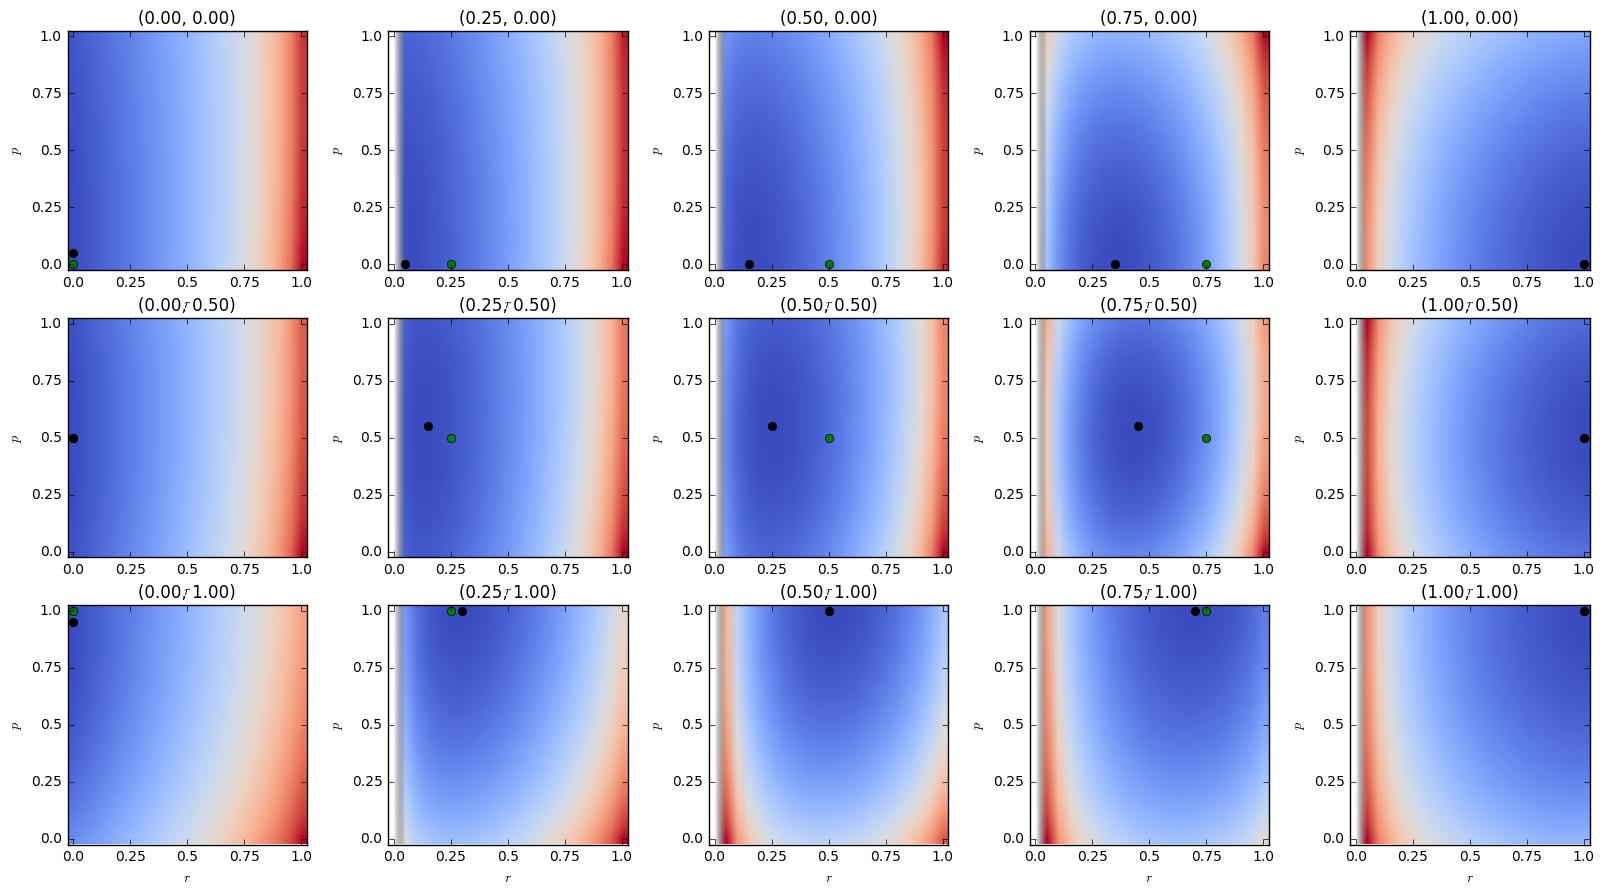

In [65]:
fig = plt.figure(figsize=(20, 10.5))
gs = gridspec.GridSpec(3, 5)
i = 0
step = 0.05
for p in [0, 0.5, 1]:
    for r in [0, 0.25, 0.5, 0.75, 1]:
        Da = util.read_data_single('g-%.2f-%.2f-00.csv' % (r, p))
        Za = make_z2(Da, step=step)
        Za[:,0] = np.where(np.abs(Za[:,0] / Za[:,1]) > 1.2, np.nan, Za[:,0])
        ax = fig.add_subplot(gs[i])
        make_heatmap(ax, Za, r, p, title="(%.2f, %.2f)" % (r, p), step=step)   
        i += 1
fig.show()